In [1]:
import numpy as np
import pandas as pd
import random

from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
anime = pd.read_csv('../input/anime-recommendations-database/anime.csv')
ratings = pd.read_csv('../input/anime-recommendations-database/rating.csv')

In [3]:
data = pd.merge(ratings, anime, on='anime_id')
data = data.dropna()
data = data.drop('rating_y', axis=1)
data.rename(columns = {'rating_x':'rating'}, inplace = True)
data = data[data['rating'] != -1]
data

,user_id,anime_id,rating,name,genre,type,episodes,members
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
5,21,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
6,28,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
7,34,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
...,...,...,...,...,...,...,...,...
7813720,65175,30095,7,Qi Cai Lao Fu Zi,"Action, Comedy, Seinen",Movie,1,82
7813721,65175,30096,7,Lao Fu Zi Shui Hu Chuan,"Comedy, Historical, Seinen",Movie,1,65
7813722,65682,30450,8,Dr. Slump: Hoyoyo! Arale no Himitsu Dai Koukai...,"Comedy, Sci-Fi, Shounen",Special,1,248
7813723,69497,33484,10,Shiroi Zou,"Action, Historical, Kids",Movie,1,45


## Анализ жанров

Чтобы определить, что смотрят нынче анимешники, сначала вытащим все жанры аниме

In [4]:
dirty_genre_list = list(set(data.genre))
genre_list = list(set([g for x in dirty_genre_list for g in x.split(', ')]))
pd.Series(genre_list)

0            Hentai
1        Historical
2            Action
3           Vampire
4            Comedy
5            Sports
6              Cars
7            School
8           Shounen
9              Yaoi
10          Romance
11      Super Power
12            Music
13         Dementia
14         Thriller
15       Shounen Ai
16            Drama
17           Sci-Fi
18         Military
19          Fantasy
20            Mecha
21          Mystery
22            Harem
23           Horror
24             Kids
25           Shoujo
26             Game
27        Adventure
28            Josei
29    Slice of Life
30           Demons
31           Police
32     Martial Arts
33           Parody
34            Magic
35    Psychological
36            Ecchi
37            Space
38        Shoujo Ai
39          Samurai
40             Yuri
41           Seinen
42     Supernatural
dtype: object

Теперь проанализируем, сколько фильмов в каждом жанре

In [5]:
stats_df = pd.DataFrame(columns=['Жанр', 'Число фильмов'])
stats_df['Жанр'] = genre_list
stats_df['Число фильмов'] = 0

for g in list(set(data.genre)):
    for genre in g.split(', '):
        stats_df.loc[stats_df['Жанр'] == genre, 'Число фильмов'] += 1
    
stats_df = stats_df.sort_values(by='Число фильмов', ascending=False)

In [6]:
stats_df

,Жанр,Число фильмов
4,Comedy,1221
2,Action,1134
17,Sci-Fi,803
16,Drama,795
27,Adventure,779
19,Fantasy,761
10,Romance,744
8,Shounen,636
42,Supernatural,567
7,School,453


<AxesSubplot:xlabel='Жанр'>

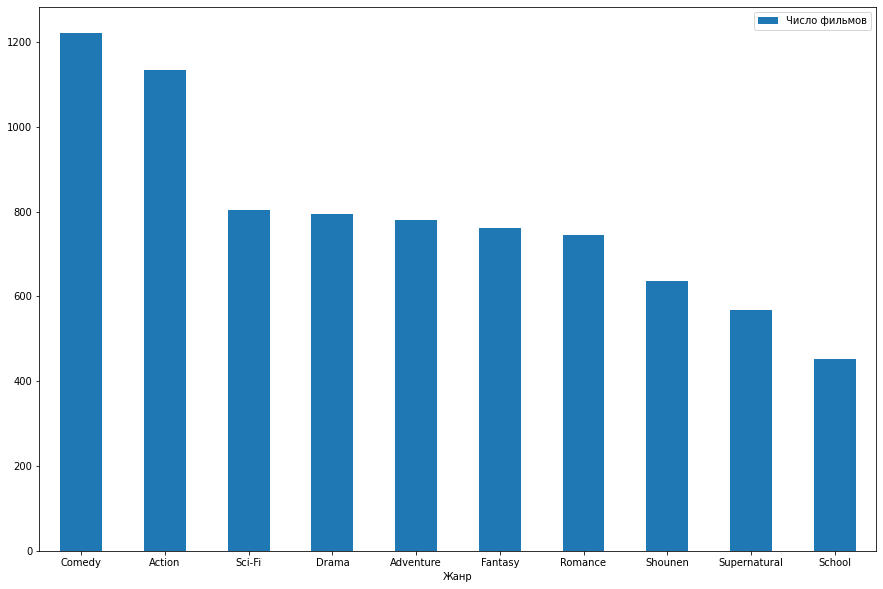

In [7]:
stats_df.set_index('Жанр').head(10).plot(kind='bar', figsize=(15, 10), rot=0)

## Выведение средней оценки аниме

Датасет предоставляет данные о отзывах людей о разных аниме, можно воспользоваться этим и найти среднее значение для каждого тайтла

In [8]:
mean_df = pd.DataFrame(columns=['Фильм', 'Средняя оценка'])
mean_df['Фильм'] = list(set(data['name']))
mean_df['Средняя оценка'] = list(data.groupby('name')['rating'].mean().round(2))
mean_df = mean_df.sort_values(by='Средняя оценка', ascending=False)
mean_df

,Фильм,Средняя оценка
4330,Bloody Night,10.0
6492,Digimon Adventure 02 Movies,10.0
3223,Utsu Musume Sayuri,10.0
3213,"Kinyoru, Abe Reiji: Heikinteki na Salaryman no...",10.0
1275,Aoki Hagane no Arpeggio: Ars Nova DC,10.0
...,...,...
4240,Gag Manga Biyori: Jump Festa 2002 Special,1.0
9517,Karo to Piyobupt: Sandwich,1.0
4263,Rekka no Honoo,1.0
8584,Tottoko Hamtarou Movie 3: Ham Ham Grand Prix A...,1.0


## Предсказание оценки на аниме

В датасете есть небольшое число признаков (`genre`, `type`, `episodes`, `members`), на основе которых можно попробовать предсказать отзыв человека. Введем целевую переменную

In [9]:
target_variable_name = 'rating'

Данные в датасете неотформатированны, в связи с чем модель будет выдавать ошибку. Исправим это

In [10]:
anime_df = anime
anime_df = anime_df.dropna()
anime_df['genre'] = anime_df['genre'].agg(lambda x: x.split(', '))
anime_df = anime_df[anime_df["episodes"].str.contains("Unknown") == False]

In [11]:
type_data = list(set(anime_df['type'].values))
labelencoder = LabelEncoder()
anime_df['type'] = labelencoder.fit_transform(anime_df['type'])

In [12]:
genre_columns = list(map(lambda x: 'genre_' + x, genre_list)) ## Создадим отдельный столбец для каждого жанра

for genre in genre_columns:
    anime_df[genre] = 0

for i, v in enumerate(anime_df['genre'].values):
    for genre in genre_list:
        if genre in v:
            anime_df.loc[anime_df['genre_' + genre], i] = 1 ## Укажем принадлежность к жанру в нужной ячейке

anime_df = anime_df.drop('genre', axis=1) ## Избавимся от лишнего столбца

Отделим тренировочные данные и значения

In [13]:
y = anime_df[target_variable_name]
X = anime_df.drop(target_variable_name, axis=1)[['type', 'episodes', 'members'] + genre_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [14]:
X_train

,type,episodes,members,genre_Hentai,genre_Historical,genre_Action,genre_Vampire,genre_Comedy,genre_Sports,genre_Cars,...,genre_Parody,genre_Magic,genre_Psychological,genre_Ecchi,genre_Space,genre_Shoujo Ai,genre_Samurai,genre_Yuri,genre_Seinen,genre_Supernatural
11436,3,1,2563,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3460,3,2,3993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9534,5,26,160,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7865,4,1,2889,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8507,1,1,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11734,3,2,1489,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5219,4,3,2371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5420,3,2,21805,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,1,58184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Обучим модель

In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Получим набор предсказаний

In [16]:
y_pred = model.predict(X_test)
y_pred

array([6.35463962, 6.09166648, 6.35448788, ..., 6.36470709, 6.36442517,
       6.63862111])

Также было бы неплохо узнать значение MAE и MSE:

In [17]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 0.8675144277172485
MAE: 0.7191412804821699


Результаты не очень хорошие. Поскольку к исходному датасету были добавлены столбцы, отвечающие за отдельный жанр, получилась ситуация, в которой много признаков, имеющих нулевое значение. Есть подозрение, что этот факт сказывается на качестве предсказаний. Потенциальное решение - использовать больше **разных** признаков, а также оставить лишь 1 жанр для тайтла. Давайте узнаем, какой вес у каждого признака

### Анализ важности признаков

In [18]:
linear_weights = abs(model.coef_)

feature_importance = pd.DataFrame(columns = ['Название признака', 'Важность признака'])
feature_importance['Название признака'] = X_test.columns
feature_importance['Важность признака'] = linear_weights
feature_importance.sort_values(by='Важность признака', ascending=False)

,Название признака,Важность признака
0,type,0.104826
1,episodes,0.000353
2,members,0.000007
44,genre_Seinen,0.000000
25,genre_Harem,0.000000
26,genre_Horror,0.000000
27,genre_Kids,0.000000
28,genre_Shoujo,0.000000
29,genre_Game,0.000000
30,genre_Adventure,0.000000


Я оказался прав

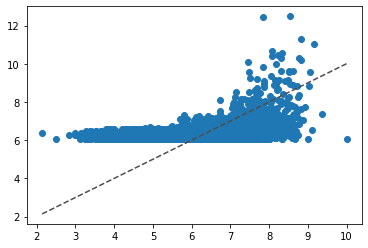

In [19]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], ls="--", c=".3")

## Предсказывание времени, которое человек потратит на тайтл

Введем задачу классификации - начнем предсказывать, сколько времени человек потратит на просмотр фильма. Поскольку таких данных в датасете нету, я буду их генерить случайно. Для простоты введем три состояния - `не просмотрит`, `просмотрит наполовину`, `просмотрит целиком`.

Кроме того, мы заметили, что разбивать столбец с жанрами отдельно на все жанры - плохая идея, так как модель оказывается весьма неточной. Поэтому каждый тайтл будет иметь **только 1 жанр**.

Этапы решения данной задачи будут следующими:
1. Оставить только один жанр у аниме
2. Случайным образом распределить статистику просмотров
3. Решить задачу классификации

### Этап первый

In [20]:
anime_df = anime
anime_df = anime_df.dropna()
anime_df['genre'] = anime_df['genre'].agg(lambda x: random.choice(x.split(', ')))
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,Romance,Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665
2,28977,Gintama°,Comedy,TV,51,9.25,114262
3,9253,Steins;Gate,Sci-Fi,TV,24,9.17,673572
4,9969,Gintama&#039;,Shounen,TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


### Этап второй

In [21]:
stats = ['Не просмотрел', 'Просмотрел половину', 'Посмотрел целиком']

In [22]:
data = pd.merge(ratings, anime_df, on='anime_id')
data = data.dropna()
data = data.drop('rating_x', axis=1)
data.rename(columns = {'rating_y':'rating'}, inplace = True)
data['watched'] = np.random.randint(2, size=data.shape[0])
data

,user_id,anime_id,name,genre,type,episodes,rating,members,watched
0,1,20,Naruto,Martial Arts,TV,220,7.81,683297,0
1,3,20,Naruto,Martial Arts,TV,220,7.81,683297,0
2,5,20,Naruto,Martial Arts,TV,220,7.81,683297,1
3,6,20,Naruto,Martial Arts,TV,220,7.81,683297,1
4,10,20,Naruto,Martial Arts,TV,220,7.81,683297,0
...,...,...,...,...,...,...,...,...,...
7813606,65682,30450,Dr. Slump: Hoyoyo! Arale no Himitsu Dai Koukai...,Sci-Fi,Special,1,6.17,248,1
7813607,69497,33484,Shiroi Zou,Action,Movie,1,4.71,45,1
7813608,70463,29481,Kakinoki Mokkii,Fantasy,Special,1,4.33,61,1
7813609,72404,34412,Hashiri Hajimeta bakari no Kimi ni,Music,Music,1,6.76,239,0
